In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix

In [19]:
df = pd.read_csv("../../csv_files/reddit_df_more_features.csv")

TEXT_COL = "text_clean"
LABEL_COL = "controversial_flag"
# Set aside numeric features
NUM_COLS = [
    "comment_upvote_ratio", "sentiment"   
]

use_cols = [TEXT_COL, LABEL_COL] + NUM_COLS
df_model = df[use_cols].dropna().copy()

#df_model.head()


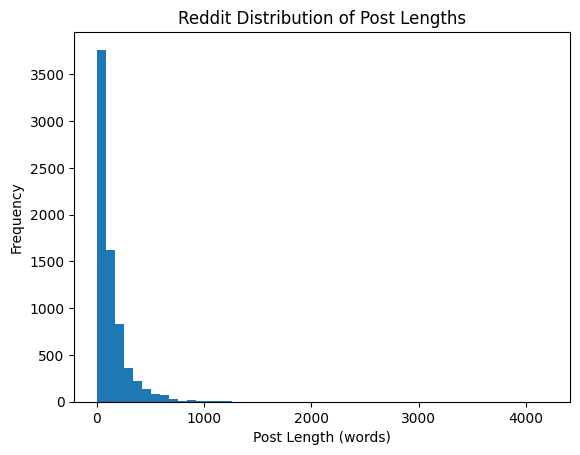

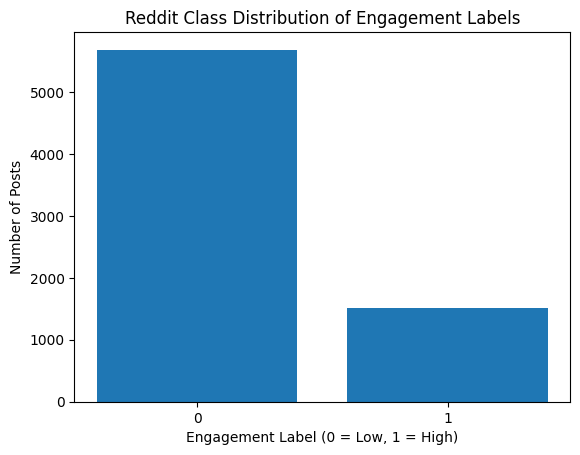

/tmp/ipykernel_3254546/15837731.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_rate = df.groupby("length_bin")[LABEL_COL].mean()


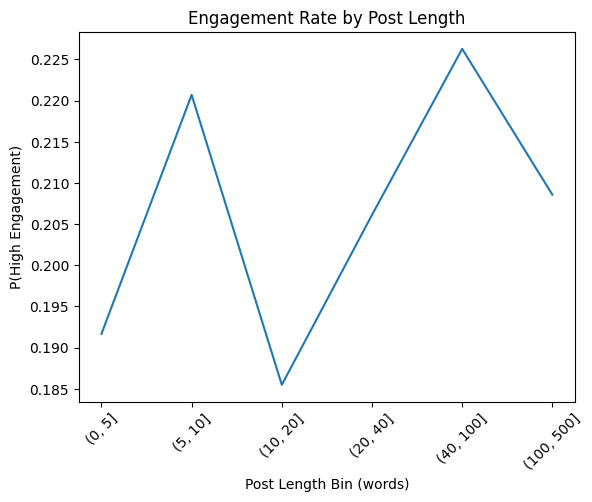

In [20]:

import matplotlib.pyplot as plt

df["post_length"] = df[TEXT_COL].str.split().str.len()

plt.figure()
plt.hist(df["post_length"], bins=50)
plt.xlabel("Post Length (words)")
plt.ylabel("Frequency")
plt.title("Reddit Distribution of Post Lengths")
plt.show()


counts = df[LABEL_COL].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Engagement Label (0 = Low, 1 = High)")
plt.ylabel("Number of Posts")
plt.title("Reddit Class Distribution of Engagement Labels")
plt.show()




import numpy as np
import matplotlib.pyplot as plt

df["length_bin"] = pd.cut(df["post_length"], bins=[0,5,10,20,40,100,500])

engagement_rate = df.groupby("length_bin")[LABEL_COL].mean()

plt.figure()
plt.plot(engagement_rate.values)
plt.xticks(range(len(engagement_rate)), engagement_rate.index.astype(str), rotation=45)
plt.xlabel("Post Length Bin (words)")
plt.ylabel("P(High Engagement)")
plt.title("Engagement Rate by Post Length")
plt.show()


In [21]:
X_train_df, X_test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model[LABEL_COL]
)

y_train = X_train_df[LABEL_COL].astype(int).values
y_test  = X_test_df[LABEL_COL].astype(int).values


tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_text = tfidf.fit_transform(X_train_df[TEXT_COL])
X_test_text  = tfidf.transform(X_test_df[TEXT_COL])

X_train_num = csr_matrix(X_train_df[NUM_COLS].astype(float).values)
X_test_num  = csr_matrix(X_test_df[NUM_COLS].astype(float).values)

scaler = StandardScaler(with_mean=False)
X_train_num = scaler.fit_transform(X_train_num)
X_test_num  = scaler.transform(X_test_num)

X_train = hstack([X_train_text, X_train_num])
X_test  = hstack([X_test_text, X_test_num])

log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train, y_train)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [22]:
y_pred = log_reg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67      1137
           1       0.13      0.22      0.16       304

    accuracy                           0.52      1441
   macro avg       0.44      0.41      0.41      1441
weighted avg       0.61      0.52      0.56      1441



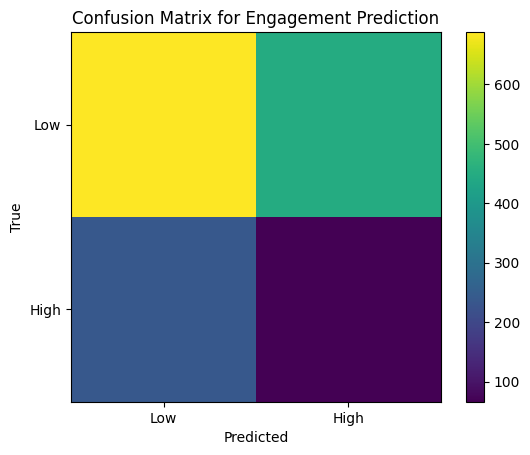

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks([0,1], ["Low", "High"])
plt.yticks([0,1], ["Low", "High"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Engagement Prediction")
plt.show()
